In [ ]:
!pip install sympy SumOfSquares

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from SumOfSquares import SOSProblem

def freePolynomial(vars, degrees) -> sp.Expr:
    from itertools import combinations_with_replacement
    if not hasattr(freePolynomial, 'i'):
        freePolynomial.i = 0
    poly = sp.S(0)
    for degree in range(0, degrees+1):
        for comb in combinations_with_replacement(vars, degree):
            if degree == 0:
                comb = [sp.S(1)]
            freePolynomial.i += 1
            poly += sp.symbols(f'c_{freePolynomial.i}', real=True) * sp.prod(comb)
    return poly

In [2]:
sin_theta, cos_theta, theta_dot = sp.symbols(r'\sin\theta \cos\theta \dot{\theta}')

g = 9.81
m = 1
l = 1
b = 0.1 # try changing the damping coefficient
theta_ddot = -g/l * sin_theta - b/(m*l**2) * theta_dot

z     = [            sin_theta,              cos_theta,  theta_dot]
z_dot = [cos_theta * theta_dot, -sin_theta * theta_dot, theta_ddot]

V = freePolynomial(z, 2)
V_dot = sp.Matrix([V]).jacobian(z).dot(z_dot)

_lambda = freePolynomial(z, 2)

prob = SOSProblem()
V_sos_constraint = prob.add_sos_constraint(V, z)
prob.add_sos_constraint(-V_dot + _lambda * (sin_theta**2 + cos_theta**2 - 1), z)

def sym_to_var(expr):
    f = sp.lambdify(prob._sym_var_map.keys(), expr)
    return f(*prob._sym_var_map.values())

# V(0) must be 0
prob.add_constraint(sym_to_var(V.subs({sin_theta:0, cos_theta:+1, theta_dot:0})) == 0)
# fix the scaling of V(x)
prob.add_constraint(sym_to_var(V.subs({sin_theta:0, cos_theta:-1, theta_dot:0})) == 2*m*g*l)

prob.solve(solver='cvxopt')
V_sos = sum(V_sos_constraint.get_sos_decomp())

print("Status: ", prob.status)
print("V:")
display(V_sos)

Status:  optimal
V:


0.498*\dot{\theta}**2 + 4.905*(1.0 - \cos\theta)**2 + 4.872*(0.008*\dot{\theta} + \sin\theta)**2

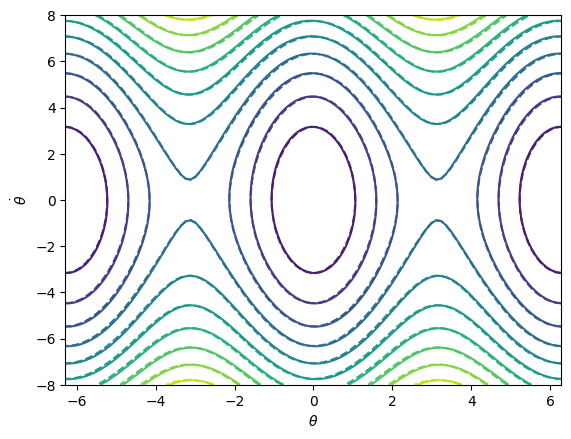

In [3]:
theta = np.linspace(-2*np.pi, 2*np.pi, 100)
theta_dot = np.linspace(-8, 8, 100)
theta, theta_dot = np.meshgrid(theta, theta_dot)

V = sp.lambdify(z, V_sos, 'numpy')
V = V(np.sin(theta), np.cos(theta), theta_dot)

E = 0.5 * m * l**2 * theta_dot**2 + m * g * l * (1 - np.cos(theta))

plt.contour(theta, theta_dot, V, levels=10, linestyles='solid')
plt.contour(theta, theta_dot, E, levels=10, linestyles='dashed')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot{\theta}$')
plt.show()